# Conditional VAE on MNIST

In this notebook we will look at the infamous Variational Auto-Encoder proposed by [Kingma and Welling 2013](https://arxiv.org/abs/1312.6114), that has formed the basis for numerous generative models available today. However, we won't just consider a "plain" VAE but instead a conditional one, where we can generate images based on conditions. In this illustrative MNIST case, the conditions will be the image class labels.

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torchvision
from lightning import LightningDataModule, Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torchseg.encoders import TimmEncoder
from torchvision.utils import make_grid

from lightning_uq_box.uq_methods import ConditionalVAE
from lightning_uq_box.viz_utils import plot_training_metrics

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(0)

Seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

The following creates a quick Datamodule for the MNIST and MNIST Fashion Dataset so that we can easily train and evaluate our model. The MNIST Fashion dataset can be used as OOD evaluation.

In [4]:
def collate_fn(batch):
    """Colate function for dataloader as dictionary."""
    images, targets = zip(*batch)
    images = torch.stack(images)
    targets = torch.tensor(targets)
    # the target is also the image, since we want to reconstruct it
    # additionally, we will have the label as a condition
    return {
        "input": images,
        "target": images,
        "condition": targets.unsqueeze(-1).float(),
    }


class MNISTDatamodule(LightningDataModule):
    def __init__(self, root: str, batch_size: int = 64, num_workers=0):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root = root

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.MNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.MNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_val,
            batch_size=self.batch_size * 10,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_test,
            batch_size=self.batch_size * 10,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )


class MNISTFashionDatamodule(MNISTDatamodule):
    """MNIST Fashion Datamodule"""

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.FashionMNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.FashionMNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )

In [5]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2)
datamodule.setup("fit")
datamodule.setup("test")

fashion_dm = MNISTFashionDatamodule(root="./data", batch_size=64, num_workers=2)
fashion_dm.setup("test")

### Example Training Samples

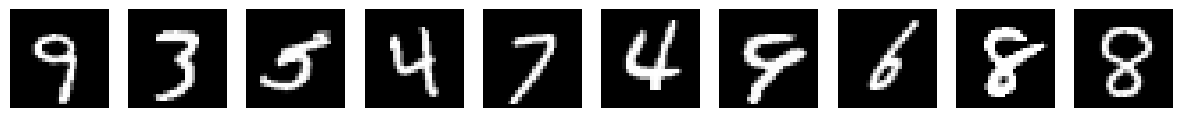

In [6]:
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
images, targets = batch["input"], batch["target"]

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap="gray")
    axes[i].axis("off")  # Hide axis

plt.show()

In [7]:
images.max()

tensor(2.8221)

In [8]:
cond_vae = ConditionalVAE(
    encoder=TimmEncoder(
        "mobilenetv3_small_050", depth=2, in_channels=2
    ),  # 1 input channel and 1 conditional channel
    latent_size=8,
    out_channels=1,
    img_size=28,
    num_conditions=10,  # number of MNIST classes
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    num_samples=5,
)

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [9]:
my_temp_dir = tempfile.mkdtemp()
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=10,
    accelerator="cpu",
    logger=logger,  # log training metrics for later evaluation
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(cond_vae, datamodule)

Missing logger folder: /tmp/tmp2yrsbneo/lightning_logs

  | Name                | Type             | Params
---------------------------------------------------------
0 | loss_fn             | VAELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | test_metrics        | MetricCollection | 0     
4 | encoder             | TimmEncoder      | 272 K 
5 | latent_mu           | Sequential       | 3.2 K 
6 | latent_log_var      | Sequential       | 3.2 K 
7 | latent_init_decoder | Sequential       | 4.0 K 
8 | decoder             | VAEDecoder       | 3.7 K 
9 | cond_embed          | Sequential       | 31    
---------------------------------------------------------
286 K     Trainable params
0         Non-trainable params
286 K     Total params
1.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


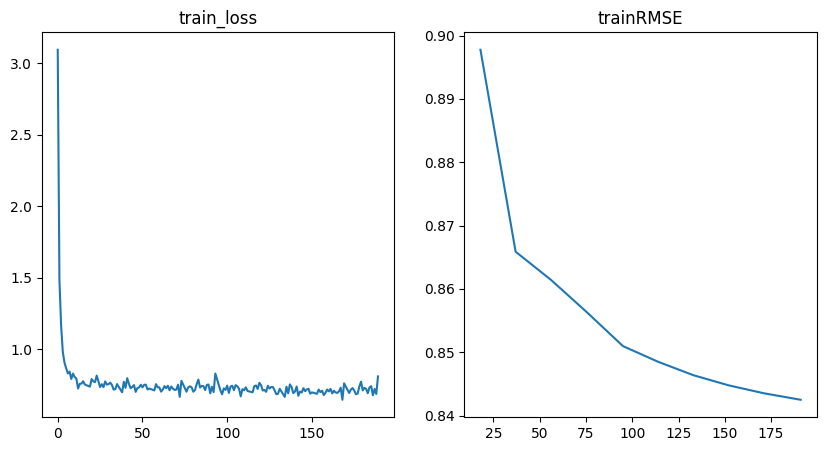

In [14]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

(-0.5, 121.5, 121.5, -0.5)

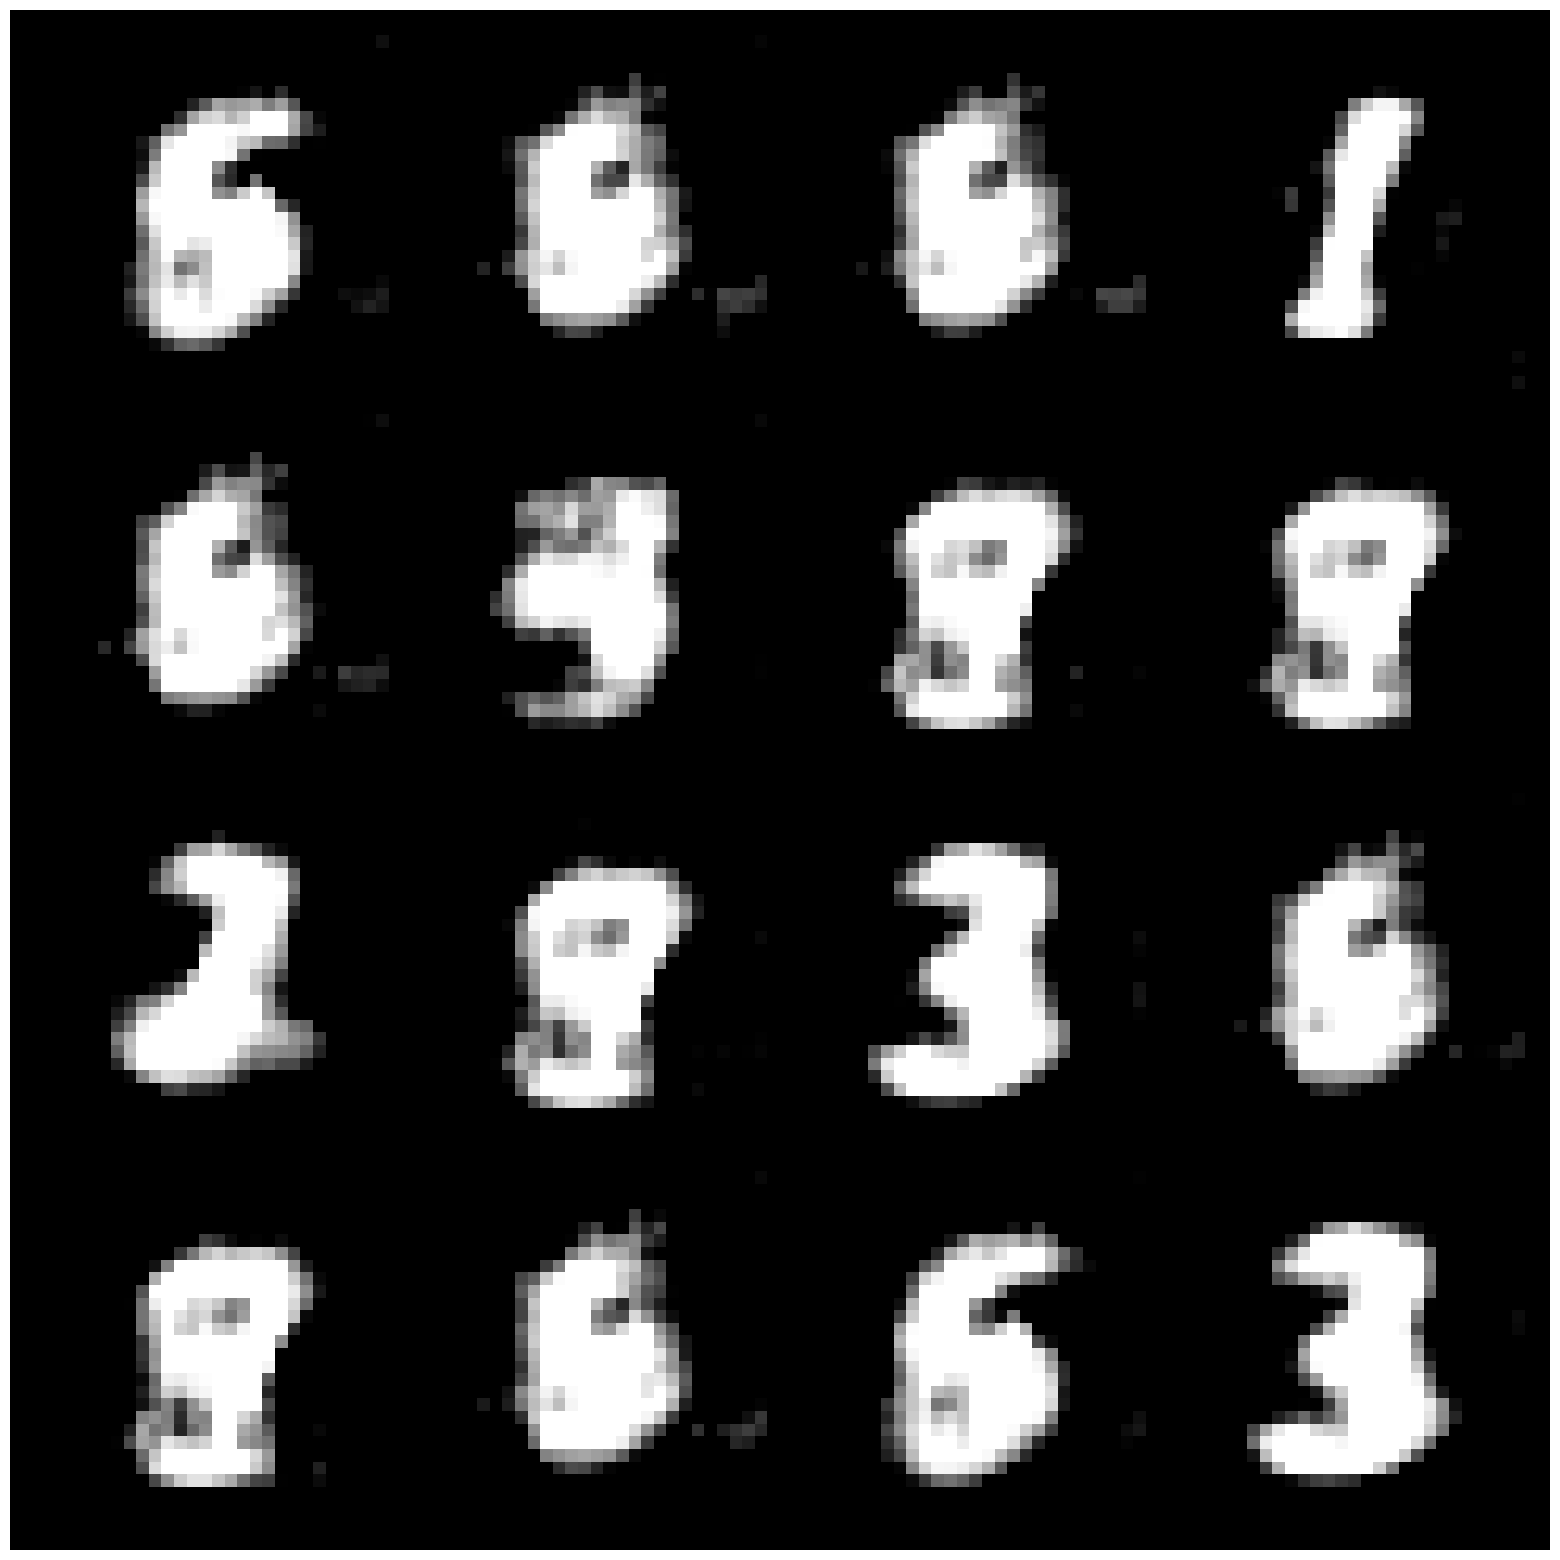

In [37]:
RANDOM = True
digit = 0
with torch.no_grad():
    if RANDOM:
        sampled_imgs = cond_vae.sample()
    else:
        sampled_imgs = cond_vae.sample(cond=torch.ones(size=(16, 1)) * digit)
    sampled_imgs = torch.clamp(sampled_imgs, 0, 1)

img_grid = make_grid(sampled_imgs, nrow=4)

fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))
ax.axis("off")